In [1]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

In [4]:
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate

DH = DataHolder(**paths)
model = GRUModel(input_dim=17) #17 for openface, 23 for opensmile

In [7]:
train_test = DH.stratified_train_test_split(feature = 'openface', speaker=1, none_count=50)
dataset = dicDataset(**train_test['data'])
class_weights = train_test['class_weights']
dataloader = DataLoader(dataset, batch_size = 100, shuffle = True, collate_fn = pad_collate)

In [8]:
model = GRUModel(input_dim=17) #17 for openface, 23 for opensmile
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

def eval_on_test():
    model.eval()
    tot_loss=0.0
    y_test = dataset.get_test()
    with torch.no_grad():
        pred = model(y_test['features'])
    loss = criterion(y_test['targets'], pred)
    tot_loss += loss / pred.shape[0]
    return loss

hist_train_loss = []
hist_test_loss = []

for epoch in range(500):
    model.train()

    epoch_loss = 0.0

    for batch in dataloader:

        pred = model(batch['features'])
        loss = criterion(batch['targets'], pred)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    hist_train_loss.append(loss)
    
    hist_test_loss.append(eval_on_test())

hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_test_loss = [x.detach().numpy() for x in hist_test_loss]

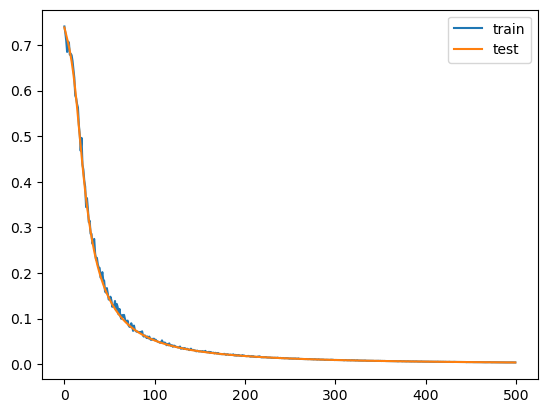

In [9]:
plt.plot(hist_train_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.legend()
plt.show()

In [19]:
class_weights

tensor([0.3871, 0.0774, 0.0667, 0.0430, 0.3376])

In [11]:
y_test = dataset.get_test()
pred = model(y_test['features'])
pred

tensor([[0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],
        [0.0026, 0.0038, 0.0025, 0.0037, 0.0021],


In [20]:
crit = torch.nn.CrossEntropyLoss()

In [54]:
crit(y_test['targets'], torch.square(torch.randn(pred.shape)))

tensor(8.7916)

In [18]:
y_test['targets']

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1